Team Gordon

Student Name	Student Number
 Alisha Sahota	20497348
 Anthony Ramelo	20499391
 Chris Wu	10182394
 Elizabeth Zhang	20161231
 Emily Zhao	10096273
 Sam Hossain	20466500


In [41]:
#Import required libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sqlalchemy import create_engine
engine = create_engine('sqlite:///:memory:')


In [42]:
#Importing Data
db_dir = os.getcwd()
db_dir = db_dir + '/MMA860_Assignment1_Data_vf.xlsx'
dfWindfarmTurbineLocations = pd.read_excel(db_dir, sheet_name='Windfarm Turbine Locations')
dfTurbineSpecifications = pd.read_excel(db_dir, sheet_name='Turbine Specifications')
dfIslandAirportWeather = pd.read_excel(db_dir, sheet_name='Island Airport Weather',skiprows=16)
dfProductSales = pd.read_excel(db_dir, sheet_name='Product_Sales')
dfCollinearity = pd.read_excel(db_dir, sheet_name='Collinearity')

In [43]:
#question 1a
# Since our weather data doesn’t include “air density”, you will need to calculate it 
# for each hour of data using the following formula and save it to a new variable and print out the first 5 records. 2 marks
# Air density (kg/m^3)=([Stn Press (kPa)]  ×1000)/(287.05×([Temp (°C)]+273.15))

dfIslandAirportWeather['Air density'] = (dfIslandAirportWeather['Stn Press (kPa)']*1000)/(287.05*(dfIslandAirportWeather['Temp (°C)']+273.15))
dfIslandAirportWeather['Air density'].head(5)

0    1.236659
1    1.232853
2    1.230567
3    1.247307
4    1.253480
Name: Air density, dtype: float64

In [44]:
# 1b.	Windspeed [Wind Spd (km/h)] will need to be converted from km/h to meters per second for 
#       each hour of data (1 km/h ≈ 0.277778 m/s). Save this to a new variable and print out the 
#       first 5 results. Include entries even if no power was generated. 2 marks

dfIslandAirportWeather['Wind Spd (m/s)'] = (dfIslandAirportWeather['Wind Spd (km/h)']*0.277778)
#Quality Check
selected_rows = dfIslandAirportWeather[['Wind Spd (km/h)','Wind Spd (m/s)']]
selected_rows.head(5)


,Wind Spd (km/h),Wind Spd (m/s)
0,11,3.055558
1,4,1.111112
2,28,7.777784
3,34,9.444452
4,28,7.777784


In [45]:
# 1c.	To calculate the power production at each turbine, use the following formula, keeping the following points in mind, save it to a new variable 
#       and print out the first 5 records. 3 marks
#       power (watts)=[Air density]× [Turbine swept area]  ×0.5[Wind speed (m/s)]^3  ×[Maximum power coefficient]
            # Points:
            # i.	If the windspeed is above or below the minimum and maximum cutoff speeds, the wind turbines will not operate
            # ii.	Each turbine cannot produce more than [Turbine nominal power] at any given point in time. Note that [Turbine nominal power] is 
            #       given in Megawatts, where your power calculation is in watts (1 MW = 1,000,000 watts)

import numpy as np

# Extracting values
TurbineSweptArea = dfTurbineSpecifications[dfTurbineSpecifications['Field'] == 'Turbine swept area']['Values'].values[0]
MinCutoffSpeed = dfTurbineSpecifications[dfTurbineSpecifications['Field'] == 'Cut-in windspeed (m/s)']['Values'].values[0]
MaxCutoffSpeed = dfTurbineSpecifications[dfTurbineSpecifications['Field'] == 'Cut-out windspeed (m/s)']['Values'].values[0]
Maximumpowercoefficient = dfTurbineSpecifications[dfTurbineSpecifications['Field'] == 'Maximum power coefficient']['Values'].values[0]
Turbinenominalpower = dfTurbineSpecifications[dfTurbineSpecifications['Field'] == 'Turbine nominal power']['Values'].values[0] * 1000000  # Converting MW to Watts

# Calculate PowerProduction
dfIslandAirportWeather['PowerProduction'] = np.where(
    (dfIslandAirportWeather['Wind Spd (m/s)'] >= MinCutoffSpeed) & 
    (dfIslandAirportWeather['Wind Spd (m/s)'] <= MaxCutoffSpeed),
    dfIslandAirportWeather['Air density'] * TurbineSweptArea * 
    (dfIslandAirportWeather['Wind Spd (m/s)']**3) * Maximumpowercoefficient * 0.5,
    0
)

# Calculate Power (Watts)
dfIslandAirportWeather['Power (Watts)'] = np.where(
    dfIslandAirportWeather['PowerProduction'] > Turbinenominalpower,
    Turbinenominalpower,
    dfIslandAirportWeather['PowerProduction']
)

# Convert Power (Watts) to Power (MW)
dfIslandAirportWeather['Power (MW)'] = dfIslandAirportWeather['Power (Watts)'] / 1000000
dfIslandAirportWeather.to_csv('newdfIslandAirportWeather.csv')
dfIslandAirportWeather['Power (Watts)'].astype(int).head(5)

0          0
1          0
2    1344892
3    2440721
4    1369934
Name: Power (Watts), dtype: int64

In [46]:
# 1d. What is the total amount of electricity produced for the entire windfarm in January in Megawatts? 
# Hint: it’s the sum of all power produced part c, above, converted to Megawatts. 1 mark

total_power_mw = dfIslandAirportWeather['Power (MW)'].sum()
print('Amount of electricity produced for the entire windfarm in January in Megawatts: ', total_power_mw * 49) #for the turbines)

Amount of electricity produced for the entire windfarm in January in Megawatts:  43077.82320367192


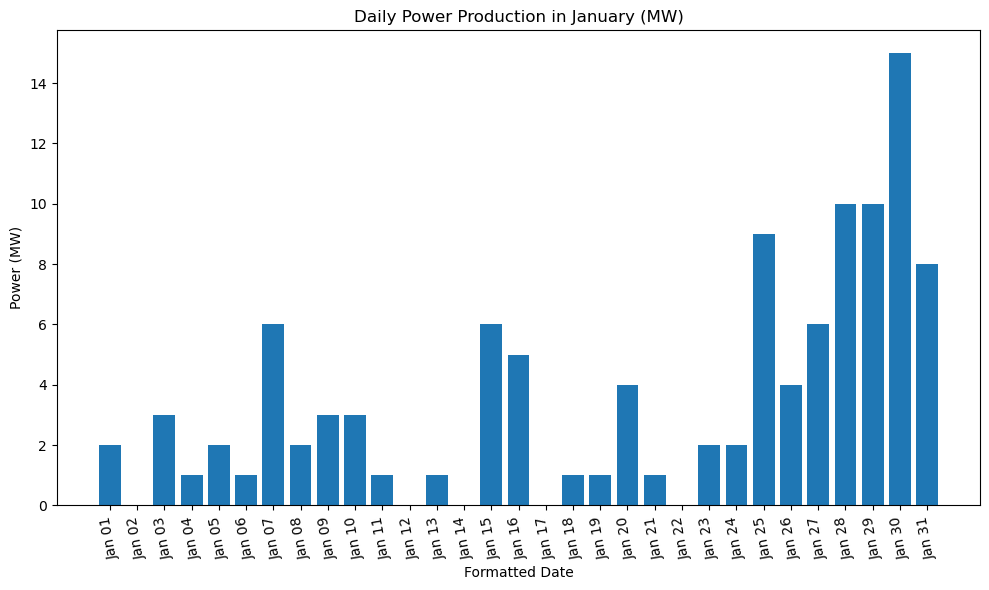

In [47]:
# 1e.	Create a visualization using the best practices we discussed showing power produced per day at the windfarm in January. 2 marks
dfIslandAirportWeather['Formatted Date'] = pd.to_datetime(dfIslandAirportWeather['Month'].astype(str) + '-' + dfIslandAirportWeather['Day'].astype(str), format='%m-%d').dt.strftime('%b %d')
plt.figure(figsize=(10, 6))
plt.bar(x=dfIslandAirportWeather['Formatted Date'], height=dfIslandAirportWeather['PowerProduction']//1000000)
plt.title('Daily Power Production in January (MW)')
plt.xlabel('Formatted Date')
plt.ylabel('Power (MW)')
plt.xticks(rotation=100)
plt.tight_layout()


# Set the y-axis to start from zero
plt.ylim(bottom=0)
plt.show()

Question 3

In [48]:
# 3a.	Make sure all variable formats are correct, and that Product_IDs are all of the same length, and a string. 2 marks
dfProductSales.dtypes
length = dfProductSales['Product_ID'].astype(str).str.len().max()
dfProductSales['Product_ID'] = dfProductSales['Product_ID'].astype(str).str.zfill(length)
dfProductSales.head(5)


,Obs,Product_ID,Sales_2016,Sales_2017,Import,Num_Retailers,Price
0,1,001,1162.91,235.19,1,5,$67.18
1,2,002,1191.11,944.87,1,3,$54.56
2,3,003,1214.96,737.06,0,5,$58.85
3,4,004,1336.07,986.15,0,7,$56.48
4,5,005,1343.29,871.33,1,7,$58.74


In [49]:
dfProductSales.dtypes

Obs                int64
Product_ID        object
Sales_2016       float64
Sales_2017       float64
Import             int64
Num_Retailers      int64
Price             object
dtype: object

In [50]:
print()
dfProductSales = dfProductSales.drop_duplicates()
#from above dtypes price needs to be float
dfProductSales['Price'] = dfProductSales['Price'].replace(r'\$','',regex = True).astype(float)
dfProductSales

,Obs,Product_ID,Sales_2016,Sales_2017,Import,Num_Retailers,Price
0,1,001,1162.91,235.19,1,5,67.18
1,2,002,1191.11,944.87,1,3,54.56
2,3,003,1214.96,737.06,0,5,58.85
3,4,004,1336.07,986.15,0,7,56.48
4,5,005,1343.29,871.33,1,7,58.74
...,...,...,...,...,...,...,...
195,196,196,1334.69,879.47,0,7,58.43
196,197,197,2035.08,1251.54,0,21,64.51
197,198,198,1390.20,1327.56,1,6,51.16
198,199,199,1968.63,2656.05,0,15,37.27


In [51]:
# 3b.	Tidy the dataset (i.e., make sure all columns are unique variables, all rows are unique observations, 
#       and there is a single data point in each cell). 2 marks
print(dfProductSales.dtypes)
print(" ")
print("Count of Missing Values:  " +str(dfProductSales.isnull().sum()))

Obs                int64
Product_ID        object
Sales_2016       float64
Sales_2017       float64
Import             int64
Num_Retailers      int64
Price            float64
dtype: object
 
Count of Missing Values:  Obs              0
Product_ID       0
Sales_2016       0
Sales_2017       0
Import           0
Num_Retailers    0
Price            0
dtype: int64


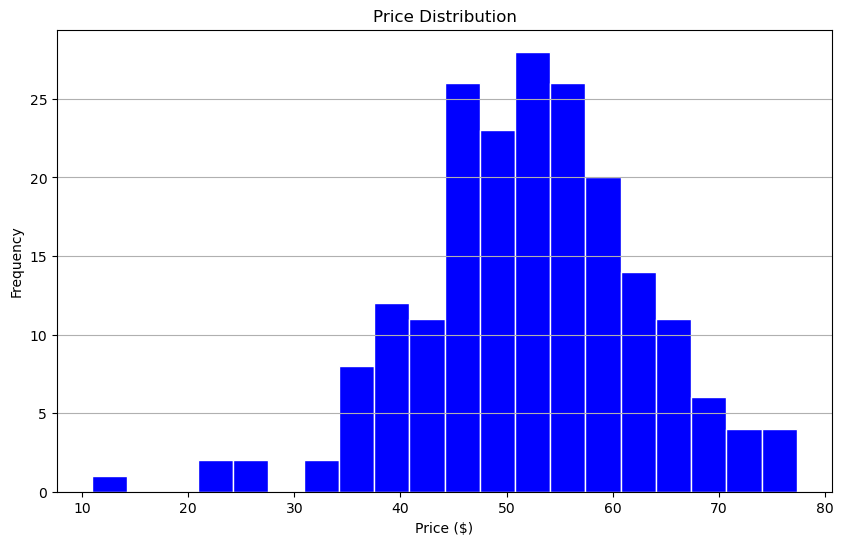

In [52]:
# 3c.	Create a visualization of price with appropriate labels. 2 marks

import matplotlib.pyplot as plt
# Histogram of the Price variable
plt.figure(figsize=(10, 6))
plt.hist(dfProductSales['Price'], bins=20, color='Blue', edgecolor='white')
plt.title('Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.grid(axis='y')

plt.show()

Correlation between  price and number of retailers:  -0.050234651544592175


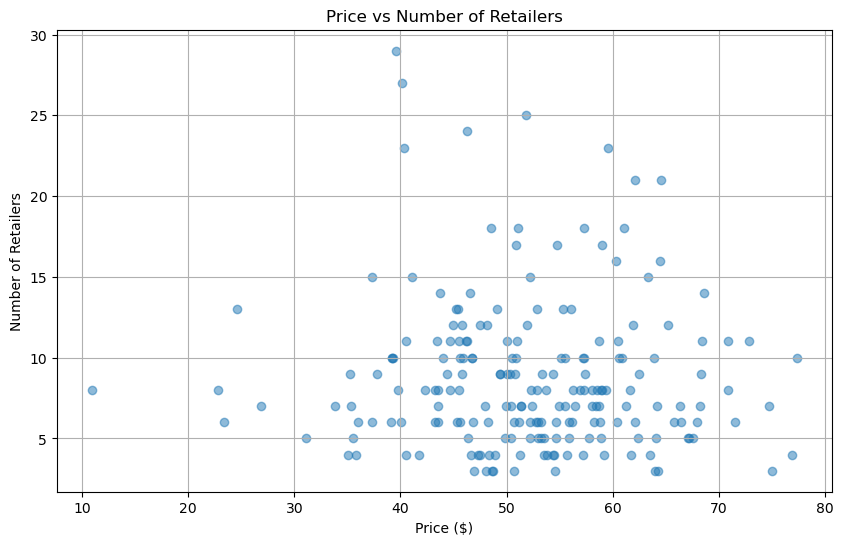

In [53]:
# 3d.	Calculate the correlation between price and number of retailers (In python: np.corrcoef()). Produce a scatterplot to visualize it, 
#       and explain what the correlation means in practical terms (i.e., to a business owner)  3 marks

correlation = np.corrcoef(dfProductSales['Price'],dfProductSales['Num_Retailers'])
correlation = correlation[0, 1]
print(f"Correlation between  price and number of retailers: ", correlation)

plt.figure(figsize=(10, 6))
plt.scatter(dfProductSales['Price'], dfProductSales['Num_Retailers'], alpha=0.5)
plt.title('Price vs Number of Retailers')
plt.xlabel('Price ($)')
plt.ylabel('Number of Retailers')
plt.grid(True)
plt.show()#A correlation coefficient close to 0 suggests no strong linear relationship between the price and the number of retailers.
#This means that changes in the price are unlikely to significantly affect how widely the product is distributed among retailers.

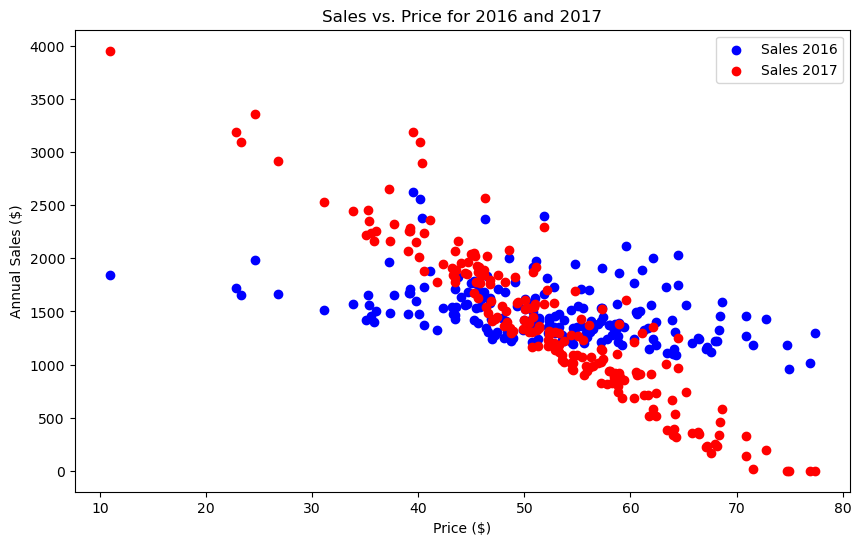

In [54]:
# 3e.	Tell a story with the data - produce an easy to understand visualization and describe the insights you’ve identified to your manager. 
#       Make sure the visualization can stand on its own without explanation, and that your story has a specific business purpose or outcome. 3 marks

import seaborn as sns
dfProductSales['Price_Clean'] = dfProductSales['Price'].replace('[\$,]', '', regex=True).astype(float)

plt.figure(figsize=(10, 6))
plt.scatter(dfProductSales['Price_Clean'], dfProductSales['Sales_2016'], color='blue', label='Sales 2016')
plt.scatter(dfProductSales['Price_Clean'], dfProductSales['Sales_2017'], color='red', label='Sales 2017')

# Adding labels and title
plt.xlabel('Price ($)')
plt.ylabel('Annual Sales ($)')
plt.title('Sales vs. Price for 2016 and 2017')
plt.legend()

# Show the plot
plt.show()


Annual sales appears more sensitive to higher prices in 2017 compared to 2016, where annual sales were more constant across a range of lower to higher prices.

In [55]:
# 4a.Collinearity: collections of variables that tend to move together, such as height and weight, are called collinear.  This creates some challenges for analysis in that individual t-statistics tend to be less informative.  
#       Using the data found on the tab ‘Collinear’:
    # a.	Filter the data to consider only the first 25 observations then run the following models; repeat the analysis with all 100 observations. You do not need to worry about standard data problems such as 
    # heteroscedasticity, etc. You must run 6 regressions in total – i, ii, and iii with 25 observations + i, ii, iii with 100 observations. Include a summary of your models and how you reached your conclusion.
        # i.	Run a linear regression to explain y in terms of experience and height.  Does height appear to explain y? 2 marks x2
        # ii.	Run a linear regression to explain y in terms of experience and weight.  Does weight appear to explain y? 2 marks x2
        # iii.	Run a linear regression to explain y in terms of experience and height and weight. Do height and weight appear to explain y? 2 marks x2

import statsmodels.api as sm
from statsmodels.formula.api import ols

dfCollinearity25 = pd.read_excel(db_dir, sheet_name='Collinearity',nrows=25)

print('25 Observations: Y ~ Height + Experience')
model = ols('Y ~ Height + Experience',dfCollinearity25).fit()
print(model.summary())


25 Observations: Y ~ Height + Experience
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     79.49
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           8.56e-11
Time:                        12:05:09   Log-Likelihood:                -138.40
No. Observations:                  25   AIC:                             282.8
Df Residuals:                      22   BIC:                             286.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  

The low p-value for height (0.005) indicates that height is a significant predictor of y in this model. Height significantly explains y.  with every unit increase in height leading to an increase of approximately 1.67 in y.The R-squared value of 0.878 suggests that approximately 87.8% of the variability in y can be explained by the model.

In [56]:
print('25 Observations: Y ~ Weight + Experience')
model = ols('Y ~ Weight + Experience',dfCollinearity25).fit()
print(model.summary())

25 Observations: Y ~ Weight + Experience
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     65.01
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           5.83e-10
Time:                        12:05:09   Log-Likelihood:                -140.58
No. Observations:                  25   AIC:                             287.2
Df Residuals:                      22   BIC:                             290.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  

The high p-value for weight (0.073) indicates that weight is not a significant predictor of y in this model. Weight does not significantly explains y.  with every unit increase in weight leading to an increase of approximately 1.60 in y.The R-squared value of 0.855 suggests that approximately 85.5% of the variability in y can be explained by the model.

In [57]:
print('25 Observations: Y ~ Height + Weight + Experience')
model = ols('Y ~ Weight + Experience + Height',dfCollinearity25).fit()
print(model.summary())

25 Observations: Y ~ Height + Weight + Experience
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     51.17
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           7.89e-10
Time:                        12:05:09   Log-Likelihood:                -138.27
No. Observations:                  25   AIC:                             284.5
Df Residuals:                      21   BIC:                             289.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
In

The high p-value for height (0.052) and weight (0.649) indicates that height and weight are not a significant predictor of y in this model. Height and weight does not significantly impact y.  with every unit increase in height and weight leading to an increase of approximately 2.06 and -0.582 respectively in y.The R-squared value of 0.880 suggests that approximately 88% of the variability in y can be explained by the model.

In [58]:
print('100 Observations: Y ~ Height+ Experience')
model = ols('Y ~ Height + Experience',dfCollinearity).fit()
print(model.summary())

100 Observations: Y ~ Height+ Experience
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     255.0
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           2.36e-39
Time:                        12:05:09   Log-Likelihood:                -540.07
No. Observations:                 100   AIC:                             1086.
Df Residuals:                      97   BIC:                             1094.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  

The low p-value for height (0.000) indicates that height is a significant predictor of y in this model. Height significantly explains y.  with every unit increase in height leading to an increase of approximately 1.28 in y.The R-squared value of 0.84 suggests that approximately 84% of the variability in y can be explained by the model.

In [59]:
print('100 Observations: Y ~ Weight +Experience')
model = ols('Y ~ Weight + Experience',dfCollinearity).fit()
print(model.summary())

100 Observations: Y ~ Weight +Experience
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     217.0
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           1.55e-36
Time:                        12:05:09   Log-Likelihood:                -546.75
No. Observations:                 100   AIC:                             1100.
Df Residuals:                      97   BIC:                             1107.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  

In [60]:
print('100 Observations: Y ~ Height + Weight + Experience')
model = ols('Y ~ Weight + Experience + Height',dfCollinearity).fit()
print(model.summary())

100 Observations: Y ~ Height + Weight + Experience
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     168.3
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           4.27e-38
Time:                        12:05:09   Log-Likelihood:                -540.07
No. Observations:                 100   AIC:                             1088.
Df Residuals:                      96   BIC:                             1099.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
I

The high p-value for weight (0.945) indicates that  weight is not a significant predictor of y in this model. Weight does not significantly impact y.  with every unit increase in height and weight leading to an increase of approximately -0.0351 in y.The R-squared value of 0.840 suggests that approximately 84% of the variability in y can be explained by the model.

The low p-value for height (0.000) indicates that height is a significant predictor of y in this model. Height significantly explains y.  with every unit increase in height leading to an increase of approximately 1.28 in y.The R-squared value of 0.840 suggests that approximately 84% of the variability in y can be explained by the model.

4b.	Consider the results you have found from the work in a. Write a paragraph or two to explain to your manager the patterns 
you observed with respect to the significance of the t-statistics, why these results occurred, 
and the strategies for using explanatory variables that exhibit collinearity. 3 marks


When analyzing the regression analysis summary for the 3 items (25 Observations): Height, Weight, Height + Weight 
having on its significance on Y. The significance of Height and Weight independently have an influence Y. But, 
when looking at both Height and Weight together. Weight does not 
have significant impact to Y.

When comparing the models using the 25 and 100 observations, the results are very different. Looking at only 
25 observations, each data point has more leverage to skew the results. By having a larger oberservations, 
it can reduce the influence of each data point and increase the reliability of the results.

Collinearity occurs when two or more predictor variables are highly correlated, making it difficult to isolate their individual effects on the dependent variable. Height and weight are naturally correlated because they both relate to physical characteristics. This correlation can inflate the variances of the coefficient estimates, leading to statistically insignificant results for one of the variables when both are included in the model